In [2]:
import pandas as pd

## Get measurements from CSV

In [3]:
sensor_readings = pd.read_csv("D:\Master\Thesis\Code\LeakDB\LeakDB-master\measurements\measurements_1_LeakDB.csv")

sensor_readings['Timestamp'] = pd.to_datetime(sensor_readings['Timestamp'])

# Extract entity ID and type
sensor_readings['entity_id'] = sensor_readings['sensor_id'].apply(lambda x: "_".join(x.split("_")[:2]))  # e.g., Node_1 or Pipe_12
sensor_readings['measurement_type'] = sensor_readings['sensor_type']  # demand, pressure, flow
sensor_readings['entity_type'] = sensor_readings['entity_id'].apply(lambda x: x.split("_")[0])  # Node or Pipe


In [4]:
# Nodes → pressure & demand
node_df = sensor_readings[sensor_readings['entity_type'] == 'Node']
node_pivot = node_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Pipes → flow
pipe_df = sensor_readings[sensor_readings['entity_type'] == 'Link']
pipe_pivot = pipe_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Rewrite column names
node_pivot.columns = ['_'.join(col).strip() for col in node_pivot.columns.values]
pipe_pivot.columns = ['_'.join(col).strip() for col in pipe_pivot.columns.values]


In [5]:
pipe_pivot

,Link_1_flow,Link_10_flow,Link_11_flow,Link_12_flow,Link_13_flow,Link_14_flow,Link_15_flow,Link_16_flow,Link_17_flow,Link_18_flow,...,Link_31_flow,Link_32_flow,Link_33_flow,Link_34_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,3405.6,352.8,270.0,172.8,190.8,82.8,39.6,68.4,-212.4,-489.6,...,25.2,-36.0,54.0,198.0,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,295.2,230.4,144.0,172.8,75.6,36.0,57.6,-194.4,-428.4,...,21.6,-32.4,46.8,169.2,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,273.6,208.8,126.0,151.2,64.8,32.4,50.4,-172.8,-388.8,...,18.0,-21.6,32.4,158.4,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,241.2,183.6,108.0,144.0,57.6,28.8,43.2,-154.8,-363.6,...,18.0,-25.2,36.0,144.0,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,219.6,165.6,100.8,133.2,57.6,28.8,36.0,-147.6,-338.4,...,14.4,-21.6,32.4,133.2,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,5652.0,579.6,439.2,273.6,313.2,129.6,61.2,126.0,-352.8,-752.4,...,46.8,-64.8,90.0,342.0,2293.2,2055.6,1746.0,1353.6,1191.6,1047.6
2017-12-31 22:00:00,5360.4,554.4,421.2,273.6,298.8,129.6,68.4,126.0,-331.2,-687.6,...,39.6,-64.8,90.0,331.2,2145.6,1940.4,1641.6,1285.2,1116.0,990.0
2017-12-31 22:30:00,4935.6,518.4,399.6,255.6,270.0,111.6,54.0,115.2,-309.6,-630.0,...,32.4,-57.6,82.8,284.4,2026.8,1814.4,1526.4,1216.8,1054.8,932.4


### Separate data by feature

In [6]:
demand_cols = [col for col in node_pivot.columns if col.endswith("demand")]
pressure_cols = [col for col in node_pivot.columns if col.endswith("pressure")]

demand_df = node_pivot[demand_cols]
pressure_df = node_pivot[pressure_cols]
flow_df = pipe_pivot

## Imputation

### Split train/val, and scale

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib

def split_scale(measurements, feature, cluster):

    # Step 1: Split the full data (X_seq or X_ori) into train and validation sets
    X_train_full, X_val_full = train_test_split(measurements, test_size=0.2, shuffle = False, random_state=42)
    # Include k cross fold validation (5 k at least)

    scaler = StandardScaler()

    # Fit and transform training data
    X_train_full_scaled = X_train_full.copy()
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns, index=X_train_full.index)

    # Save scaler with specific name for later rescaling
    joblib.dump(scaler, f"{feature}_scaler_{cluster}.pkl")

    # Now, apply ONLY transformation (not fitting) on val data
    X_val_full_scaled = X_val_full.copy()
    X_val_full_scaled = scaler.transform(X_val_full)
    X_val_full_scaled = pd.DataFrame(X_val_full_scaled, columns=X_val_full.columns, index=X_val_full.index)

    return X_train_full_scaled, X_val_full_scaled, X_train_full, X_val_full

### Select semantically relevant pipes

Cluster 0: Pipe_13, Pipe_14, Pipe_15, Pipe_17, Pipe_19, Pipe_26, Pipe_27, Pipe_28, Pipe_29, Pipe_32

Cluster 1: Pipe_1, Pipe_11, Pipe_24, Pipe_3, Pipe_4, Pipe_5, Pipe_6, Pipe_7, Pipe_8, Pipe_9

Cluster 3: Pipe_10, Pipe_18, Pipe_2, Pipe_21, Pipe_22, Pipe_25, Pipe_30, Pipe_31, Pipe_33, Pipe_34

Cluster 2: Pipe_12, Pipe_16, Pipe_20, Pipe_23

In [8]:
flow_c1 = flow_df[["Link_1_flow", "Link_11_flow", "Link_24_flow", "Link_3_flow", "Link_4_flow", "Link_5_flow", "Link_6_flow", "Link_7_flow", "Link_8_flow", "Link_9_flow"]]
flow_c0 = flow_df[["Link_13_flow", "Link_14_flow", "Link_15_flow", "Link_17_flow", "Link_19_flow", "Link_26_flow", "Link_27_flow", "Link_28_flow", "Link_29_flow", "Link_32_flow"]]
flow_c3 = flow_df[["Link_10_flow", "Link_18_flow", "Link_2_flow", "Link_21_flow", "Link_22_flow", "Link_25_flow", "Link_30_flow", "Link_31_flow", "Link_33_flow", "Link_34_flow"]]
flow_c2 = flow_df[["Link_12_flow", "Link_16_flow", "Link_20_flow", "Link_23_flow"]]
flow_all = flow_df

# Initialize the containers
X_train_full_scaled = {}
X_val_full_scaled = {}
X_train_full_unscaled = {}
X_val_full_unscaled = {}
clusters = [flow_c0, flow_c1, flow_c2, flow_c3, flow_all]

# Iterate over the clusters
for i, flow_cluster in enumerate(clusters):
    X_train_full_scaled[i], X_val_full_scaled[i], X_train_full_unscaled[i], X_val_full_unscaled[i] = split_scale(flow_cluster, "flow", i)


In [9]:
X_train_full_unscaled[1]

,Link_1_flow,Link_11_flow,Link_24_flow,Link_3_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,
2017-01-01 00:00:00,3405.6,270.0,561.6,1396.8,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,230.4,482.4,1180.8,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,208.8,435.6,1069.2,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,183.6,385.2,957.6,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,165.6,363.6,867.6,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...
2017-10-19 21:30:00,5464.8,406.8,900.0,2152.8,2124.0,1904.4,1627.2,1296.0,1137.6,1000.8
2017-10-19 22:00:00,5151.6,414.0,853.2,2077.2,2044.8,1850.4,1566.0,1260.0,1090.8,968.4
2017-10-19 22:30:00,4870.8,396.0,795.6,1998.0,1969.2,1771.2,1501.2,1202.4,1047.6,914.4


In [10]:
def sliding_window_3d(data, window_size, stride):
    """
    Converts a long time series [1, T, F] into [N, window_size, F]
    """
    data = data.squeeze(0)  # [T, F]
    total_steps, n_features = data.shape
    windows = []

    for i in range(0, total_steps - window_size + 1, stride):
        window = data[i:i+window_size]
        windows.append(window)

    return np.stack(windows)

### Introduce MAR Missingness

In [11]:
from pygrinder import mar_logistic

missing_rates = [0.05, 0.4, 0.6, 0.99]

# Training and validation sets for each cluster
X_train_incomplete = {}
X_val_incomplete = {}
train_masks = {}
val_masks = {}
X_train_seq = {}
X_val_seq = {}
train_masks_seq = {}
val_masks_seq = {}

# Full tensors for each cluster
X_train_full_tensor = {}
X_val_full_tensor = {}
X_val_full_seq = {}
X_train_full_seq = {}
X_train_full_unscaled_seq_tensor = {}
X_val_full_unscaled_seq_tensor = {}


n_steps = 168 # 3.5 days each window
stride = 48 # 1 day stride

for cluster_id, flow_cluster in enumerate(clusters):
    X_train_incomplete[cluster_id] = {}
    X_val_incomplete[cluster_id] = {}
    train_masks[cluster_id] = {}
    val_masks[cluster_id] = {}
    X_train_seq[cluster_id] = {}
    X_val_seq[cluster_id] = {}
    train_masks_seq[cluster_id] = {}
    val_masks_seq[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)

        # Introduce missingness per cluster & rate
        print(f"Introducing {rate*100}% missingness for cluster {cluster_id} with key {key}")

        # Apply MNAR-x missingness
        X_train_incomplete[cluster_id][key] = mar_logistic(X_train_full_scaled[cluster_id].values, obs_rate=0.4, missing_rate=rate)
        X_val_incomplete[cluster_id][key] = mar_logistic(X_val_full_scaled[cluster_id].values, obs_rate=0.4, missing_rate=rate)

        # Masks for missingness
        train_masks[cluster_id][key] = np.isnan(X_train_incomplete[cluster_id][key])
        val_masks[cluster_id][key] = np.isnan(X_val_incomplete[cluster_id][key])

        actual_missing_rate = train_masks[cluster_id][key].mean()
        print(f"Actual missing rate: {actual_missing_rate:.2%}")
        
        # Expand dims for batch axis (needed for sliding window)
        X_train_tensor = np.expand_dims(X_train_incomplete[cluster_id][key], axis=0)
        X_val_tensor = np.expand_dims(X_val_incomplete[cluster_id][key], axis=0)
        train_mask_tensor = np.expand_dims(train_masks[cluster_id][key], axis=0)
        val_mask_tensor = np.expand_dims(val_masks[cluster_id][key], axis=0)

        # Sliding window on data
        X_train_seq[cluster_id][key] = sliding_window_3d(X_train_tensor, window_size=n_steps, stride=stride)
        X_val_seq[cluster_id][key] = sliding_window_3d(X_val_tensor, window_size=n_steps, stride=stride)

        # Sliding window on masks
        train_masks_seq[cluster_id][key] = sliding_window_3d(train_mask_tensor, window_size=n_steps, stride=stride)
        val_masks_seq[cluster_id][key] = sliding_window_3d(val_mask_tensor, window_size=n_steps, stride=stride)


    # Expand full training tensors
    X_train_full_tensor[cluster_id] = np.expand_dims(X_train_full_scaled[cluster_id].values, axis = 0)

    # Expand full validation tensors
    X_val_full_tensor[cluster_id] = np.expand_dims(X_val_full_scaled[cluster_id].values, axis = 0)

    # Convert scaled data to tensor
    X_val_full_seq[cluster_id] = sliding_window_3d(X_val_full_tensor[cluster_id], window_size=n_steps, stride=stride)
    X_train_full_seq[cluster_id] = sliding_window_3d(X_train_full_tensor[cluster_id], window_size=n_steps, stride=stride)

    # Convert unscaled data to tensor
    X_train_full_unscaled_values = np.expand_dims(X_train_full_unscaled[cluster_id].values, axis=0)
    X_train_full_unscaled_seq_tensor[cluster_id] = sliding_window_3d(X_train_full_unscaled_values, window_size=n_steps, stride=stride)

    X_val_full_unscaled_values = np.expand_dims(X_val_full_unscaled[cluster_id].values, axis=0)
    X_val_full_unscaled_seq_tensor[cluster_id] = sliding_window_3d(X_val_full_unscaled_values, window_size=n_steps, stride=stride)

Introducing 5.0% missingness for cluster 0 with key 5
Actual missing rate: 2.98%
Introducing 40.0% missingness for cluster 0 with key 40
Actual missing rate: 24.27%
Introducing 60.0% missingness for cluster 0 with key 60
Actual missing rate: 35.95%
Introducing 99.0% missingness for cluster 0 with key 99
Actual missing rate: 59.41%
Introducing 5.0% missingness for cluster 1 with key 5
Actual missing rate: 2.96%
Introducing 40.0% missingness for cluster 1 with key 40
Actual missing rate: 24.00%
Introducing 60.0% missingness for cluster 1 with key 60
Actual missing rate: 35.84%
Introducing 99.0% missingness for cluster 1 with key 99
Actual missing rate: 59.40%
Introducing 5.0% missingness for cluster 2 with key 5
Actual missing rate: 3.64%
Introducing 40.0% missingness for cluster 2 with key 40
Actual missing rate: 29.83%
Introducing 60.0% missingness for cluster 2 with key 60
Actual missing rate: 44.92%
Introducing 99.0% missingness for cluster 2 with key 99
Actual missing rate: 74.27%
I

In [12]:
# Step 3: Prepare the final datasets with 'X' (incomplete) and 'X_ori' (full data)

# 20 percent missing
train_data, val_data = {}, {}

for cluster_id in range(len(clusters)):
    train_data[cluster_id] = {}
    val_data[cluster_id] = {}
    
    for rate in missing_rates:
        key = int(rate * 100)
        
        # Prepare the train and validation data dictionaries for each missing rate
        train_data[cluster_id][key] = {"X": X_train_seq[cluster_id][key]}
        val_data[cluster_id][key] = {"X": X_val_seq[cluster_id][key], "X_ori": X_val_full_seq[cluster_id]}

### Mean Imputation

In [13]:
def mean_impute(X_incomplete):
    """
    Impute missing values using feature-wise mean over the entire dataset.
    Assumes input shape is [n_samples, n_steps, n_features].
    """
    X_imputed = X_incomplete.copy()
    n_features = X_imputed.shape[2]

    for f in range(n_features):
        feature_data = X_imputed[:, :, f]
        mean_val = np.nanmean(feature_data)
        feature_data[np.isnan(feature_data)] = mean_val
        X_imputed[:, :, f] = feature_data

    return X_imputed


In [14]:
# Dictionary to hold results
mean_imputed_results = {}
missing_masks = {}

for cluster_idx, cluster_data in enumerate(X_val_seq):
    mean_imputed_results[cluster_idx] = {}
    missing_masks[cluster_idx] = {}
    
    for rate in missing_rates:
        key = int(rate * 100)
        X_missing = X_val_seq[cluster_idx][key]
        
        # Impute using mean
        X_imputed = mean_impute(X_missing)
        mean_imputed_results[cluster_idx][key] = X_imputed

        # Create missing mask
        missing_mask = np.isnan(X_missing)
        missing_masks[cluster_idx][key] = missing_mask


In [15]:
import joblib

imputed_unscaled_mean = {}

for cluster_id in range(len(clusters)):
    imputed_unscaled_mean[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")
    
# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        n_samples, n_steps, n_features = mean_imputed_results[cluster_id][key].shape
        tensor_2d = mean_imputed_results[cluster_id][key].reshape(-1, n_features)  # Flatten time dimension
        tensor_2d_unscaled = scaler.inverse_transform(tensor_2d)
        imputed_unscaled_mean[cluster_id][key] = tensor_2d_unscaled.reshape(n_samples, n_steps, n_features)

In [16]:
# Calculate MAE for imputation evaluation

# Calculate MAE for imputation evaluation

mae_mean = {}
for cluster_id in range(len(clusters)):
    mae_mean[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)
        mae_mean[cluster_id][key] = np.mean(np.abs(imputed_unscaled_mean[cluster_id][key][val_masks_seq[cluster_id][key]] - X_val_full_unscaled_seq_tensor[cluster_id][val_masks_seq[cluster_id][key]]))
        print(f"MAE Cluster {cluster_id} Rate {rate*100}% (MAE): {mae_mean[cluster_id][key]}")

MAE Cluster 0 Rate 5.0% (MAE): 81.42315184104845
MAE Cluster 0 Rate 40.0% (MAE): 87.13127596943515
MAE Cluster 0 Rate 60.0% (MAE): 73.10090039452936
MAE Cluster 0 Rate 99.0% (MAE): 85.48743541962585
MAE Cluster 1 Rate 5.0% (MAE): 707.7912504084583
MAE Cluster 1 Rate 40.0% (MAE): 565.6162554813036
MAE Cluster 1 Rate 60.0% (MAE): 689.7286682186259
MAE Cluster 1 Rate 99.0% (MAE): 691.1713973392746
MAE Cluster 2 Rate 5.0% (MAE): 176.82281104347925
MAE Cluster 2 Rate 40.0% (MAE): 190.8460027593263
MAE Cluster 2 Rate 60.0% (MAE): 248.82809587549121
MAE Cluster 2 Rate 99.0% (MAE): 186.62160267195807
MAE Cluster 3 Rate 5.0% (MAE): 397.126233579805
MAE Cluster 3 Rate 40.0% (MAE): 309.0796120508572
MAE Cluster 3 Rate 60.0% (MAE): 108.99562330549843
MAE Cluster 3 Rate 99.0% (MAE): 68.81730171472758
MAE Cluster 4 Rate 5.0% (MAE): 267.33689918535816
MAE Cluster 4 Rate 40.0% (MAE): 185.70176583754392
MAE Cluster 4 Rate 60.0% (MAE): 280.8000989880321
MAE Cluster 4 Rate 99.0% (MAE): 275.5950237009221


In [17]:
#SMAPE for each percentage of missingness
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        numerator = np.abs((imputed_unscaled_mean[cluster_id][key][val_masks_seq[cluster_id][key]] - X_val_full_unscaled_seq_tensor[cluster_id][val_masks_seq[cluster_id][key]]))
        denominator = np.abs(imputed_unscaled_mean[cluster_id][key][val_masks_seq[cluster_id][key]]) + np.abs(X_val_full_unscaled_seq_tensor[cluster_id][val_masks_seq[cluster_id][key]]) + 1e-8
        smape[cluster_id][key] = 100 * np.mean(2 * numerator / denominator)
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")

SMAPE Cluster 0 Rate 5.0%: 42.75%
SMAPE Cluster 0 Rate 40.0%: 29.77%
SMAPE Cluster 0 Rate 60.0%: 46.54%
SMAPE Cluster 0 Rate 99.0%: 45.02%
SMAPE Cluster 1 Rate 5.0%: 32.98%
SMAPE Cluster 1 Rate 40.0%: 34.26%
SMAPE Cluster 1 Rate 60.0%: 36.23%
SMAPE Cluster 1 Rate 99.0%: 41.50%
SMAPE Cluster 2 Rate 5.0%: 33.71%
SMAPE Cluster 2 Rate 40.0%: 40.48%
SMAPE Cluster 2 Rate 60.0%: 39.73%
SMAPE Cluster 2 Rate 99.0%: 36.37%
SMAPE Cluster 3 Rate 5.0%: 38.23%
SMAPE Cluster 3 Rate 40.0%: 34.54%
SMAPE Cluster 3 Rate 60.0%: 35.62%
SMAPE Cluster 3 Rate 99.0%: 36.73%
SMAPE Cluster 4 Rate 5.0%: 36.98%
SMAPE Cluster 4 Rate 40.0%: 37.08%
SMAPE Cluster 4 Rate 60.0%: 38.98%
SMAPE Cluster 4 Rate 99.0%: 37.40%


### BRITS Imputation

In [18]:
from pypots.imputation import BRITS
from pypots.nn.modules.loss import MAE, MSE
from pypots.optim.adam import Adam
import torch

def intialize_BRITS(n_steps, num_features, rnn_hidden_size):

    # Basic configuration
    model = BRITS(
        n_steps=n_steps,
        n_features=num_features,
        rnn_hidden_size=rnn_hidden_size,               # Reasonable hidden size
        batch_size=32,                    # Standard for most datasets
        epochs=25,                       # Higher epochs for better convergence
        patience=5,                      # Early stopping if no improvement
        training_loss=MAE,                # MAE often performs well for imputation
        validation_metric=MSE,           # Use MSE for validation comparison
        optimizer=Adam,                   # Adam optimizer (default)
        num_workers=0,                    # Adjust if using DataLoader with multiprocessing
        device="cuda" if torch.cuda.is_available() else "cpu",  # Use GPU if available
        saving_path="./brits_model",     # Directory to save model checkpoints
        model_saving_strategy="best",    # Save best model only
        verbose=True                      # Print training progress
    )

    return model

d:\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [19]:
models = {}
rnn_hidden = 0
# Initialize and fit BRITS models for each missing rate

for cluster_id in range(len(clusters)):
    print(f"Training BRITS models for cluster {cluster_id}...")
    models[cluster_id] = {}
    for rate in missing_rates:
        print(f"Training model for missing rate {rate} in cluster {cluster_id}...")
        key = int(rate * 100)

        _, n_steps, n_features = train_data[cluster_id][key]["X"].shape
        
        # Reduce complexity of model for less features
        if cluster_id != len(clusters) - 1:
            rnn_hidden = 16
        else:
            rnn_hidden = 32
        
        models[cluster_id][key] = intialize_BRITS(n_steps, n_features, rnn_hidden)
        models[cluster_id][key].fit(train_data[cluster_id][key], val_set=val_data[cluster_id][key])

2025-06-26 22:36:03 [INFO]: Using the given device: cpu
2025-06-26 22:36:03 [INFO]: Model files will be saved to ./brits_model\20250626_T223603
2025-06-26 22:36:03 [INFO]: Tensorboard file will be saved to ./brits_model\20250626_T223603\tensorboard
2025-06-26 22:36:03 [INFO]: Using customized MAE as the training loss function.
2025-06-26 22:36:03 [INFO]: Using customized MSE as the validation metric function.
2025-06-26 22:36:03 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 6,416


Training BRITS models for cluster 0...
Training model for missing rate 0.05 in cluster 0...


2025-06-26 22:36:12 [INFO]: Epoch 001 - training loss (MAE): 1.8158, validation MSE: 1.8436
2025-06-26 22:36:17 [INFO]: Epoch 002 - training loss (MAE): 1.7498, validation MSE: 1.5725
2025-06-26 22:36:22 [INFO]: Epoch 003 - training loss (MAE): 1.5871, validation MSE: 1.3060
2025-06-26 22:36:27 [INFO]: Epoch 004 - training loss (MAE): 1.4474, validation MSE: 1.0460
2025-06-26 22:36:33 [INFO]: Epoch 005 - training loss (MAE): 1.3245, validation MSE: 0.8135
2025-06-26 22:36:38 [INFO]: Epoch 006 - training loss (MAE): 1.1917, validation MSE: 0.6145
2025-06-26 22:36:43 [INFO]: Epoch 007 - training loss (MAE): 1.0664, validation MSE: 0.4454
2025-06-26 22:36:47 [INFO]: Epoch 008 - training loss (MAE): 0.9711, validation MSE: 0.3132
2025-06-26 22:36:52 [INFO]: Epoch 009 - training loss (MAE): 0.8495, validation MSE: 0.2179
2025-06-26 22:36:57 [INFO]: Epoch 010 - training loss (MAE): 0.7669, validation MSE: 0.1518
2025-06-26 22:37:02 [INFO]: Epoch 011 - training loss (MAE): 0.7087, validation 

Training model for missing rate 0.4 in cluster 0...


2025-06-26 22:38:18 [INFO]: Epoch 001 - training loss (MAE): 1.9258, validation MSE: 0.9209
2025-06-26 22:38:23 [INFO]: Epoch 002 - training loss (MAE): 1.8178, validation MSE: 0.8205
2025-06-26 22:38:28 [INFO]: Epoch 003 - training loss (MAE): 1.7085, validation MSE: 0.7131
2025-06-26 22:38:34 [INFO]: Epoch 004 - training loss (MAE): 1.5854, validation MSE: 0.5986
2025-06-26 22:38:39 [INFO]: Epoch 005 - training loss (MAE): 1.4702, validation MSE: 0.4784
2025-06-26 22:38:45 [INFO]: Epoch 006 - training loss (MAE): 1.3205, validation MSE: 0.3686
2025-06-26 22:38:50 [INFO]: Epoch 007 - training loss (MAE): 1.1883, validation MSE: 0.2708
2025-06-26 22:38:55 [INFO]: Epoch 008 - training loss (MAE): 1.0474, validation MSE: 0.1895
2025-06-26 22:39:01 [INFO]: Epoch 009 - training loss (MAE): 0.9181, validation MSE: 0.1278
2025-06-26 22:39:06 [INFO]: Epoch 010 - training loss (MAE): 0.8063, validation MSE: 0.0887
2025-06-26 22:39:11 [INFO]: Epoch 011 - training loss (MAE): 0.7214, validation 

Training model for missing rate 0.6 in cluster 0...


2025-06-26 22:40:31 [INFO]: Epoch 001 - training loss (MAE): 1.7740, validation MSE: 0.9751
2025-06-26 22:40:36 [INFO]: Epoch 002 - training loss (MAE): 1.6884, validation MSE: 0.8822
2025-06-26 22:40:42 [INFO]: Epoch 003 - training loss (MAE): 1.6350, validation MSE: 0.7857
2025-06-26 22:40:47 [INFO]: Epoch 004 - training loss (MAE): 1.5039, validation MSE: 0.6821
2025-06-26 22:40:52 [INFO]: Epoch 005 - training loss (MAE): 1.3886, validation MSE: 0.5754
2025-06-26 22:40:58 [INFO]: Epoch 006 - training loss (MAE): 1.2777, validation MSE: 0.4757
2025-06-26 22:41:03 [INFO]: Epoch 007 - training loss (MAE): 1.1563, validation MSE: 0.3886
2025-06-26 22:41:09 [INFO]: Epoch 008 - training loss (MAE): 1.0520, validation MSE: 0.3130
2025-06-26 22:41:14 [INFO]: Epoch 009 - training loss (MAE): 0.9350, validation MSE: 0.2495
2025-06-26 22:41:19 [INFO]: Epoch 010 - training loss (MAE): 0.8252, validation MSE: 0.2008
2025-06-26 22:41:25 [INFO]: Epoch 011 - training loss (MAE): 0.7254, validation 

Training model for missing rate 0.99 in cluster 0...


2025-06-26 22:42:48 [INFO]: Epoch 001 - training loss (MAE): 1.8029, validation MSE: 0.9341
2025-06-26 22:42:53 [INFO]: Epoch 002 - training loss (MAE): 1.7065, validation MSE: 0.9159
2025-06-26 22:42:58 [INFO]: Epoch 003 - training loss (MAE): 1.6493, validation MSE: 0.8994
2025-06-26 22:43:04 [INFO]: Epoch 004 - training loss (MAE): 1.5444, validation MSE: 0.8831
2025-06-26 22:43:09 [INFO]: Epoch 005 - training loss (MAE): 1.4194, validation MSE: 0.8662
2025-06-26 22:43:15 [INFO]: Epoch 006 - training loss (MAE): 1.2920, validation MSE: 0.8432
2025-06-26 22:43:20 [INFO]: Epoch 007 - training loss (MAE): 1.1514, validation MSE: 0.8108
2025-06-26 22:43:25 [INFO]: Epoch 008 - training loss (MAE): 1.0015, validation MSE: 0.7793
2025-06-26 22:43:31 [INFO]: Epoch 009 - training loss (MAE): 0.8541, validation MSE: 0.7574
2025-06-26 22:43:36 [INFO]: Epoch 010 - training loss (MAE): 0.7149, validation MSE: 0.7354
2025-06-26 22:43:41 [INFO]: Epoch 011 - training loss (MAE): 0.6103, validation 

Training BRITS models for cluster 1...
Training model for missing rate 0.05 in cluster 1...


2025-06-26 22:45:04 [INFO]: Epoch 001 - training loss (MAE): 1.7133, validation MSE: 0.8733
2025-06-26 22:45:10 [INFO]: Epoch 002 - training loss (MAE): 1.5899, validation MSE: 0.7483
2025-06-26 22:45:15 [INFO]: Epoch 003 - training loss (MAE): 1.4479, validation MSE: 0.6181
2025-06-26 22:45:21 [INFO]: Epoch 004 - training loss (MAE): 1.3200, validation MSE: 0.4855
2025-06-26 22:45:26 [INFO]: Epoch 005 - training loss (MAE): 1.1555, validation MSE: 0.3719
2025-06-26 22:45:32 [INFO]: Epoch 006 - training loss (MAE): 1.0059, validation MSE: 0.2754
2025-06-26 22:45:38 [INFO]: Epoch 007 - training loss (MAE): 0.8617, validation MSE: 0.1936
2025-06-26 22:45:43 [INFO]: Epoch 008 - training loss (MAE): 0.7313, validation MSE: 0.1301
2025-06-26 22:45:48 [INFO]: Epoch 009 - training loss (MAE): 0.6146, validation MSE: 0.0828
2025-06-26 22:45:53 [INFO]: Epoch 010 - training loss (MAE): 0.5217, validation MSE: 0.0495
2025-06-26 22:45:58 [INFO]: Epoch 011 - training loss (MAE): 0.4495, validation 

Training model for missing rate 0.4 in cluster 1...


2025-06-26 22:47:20 [INFO]: Epoch 001 - training loss (MAE): 1.6897, validation MSE: 0.6197
2025-06-26 22:47:25 [INFO]: Epoch 002 - training loss (MAE): 1.5825, validation MSE: 0.5132
2025-06-26 22:47:29 [INFO]: Epoch 003 - training loss (MAE): 1.4528, validation MSE: 0.4028
2025-06-26 22:47:35 [INFO]: Epoch 004 - training loss (MAE): 1.3292, validation MSE: 0.2998
2025-06-26 22:47:40 [INFO]: Epoch 005 - training loss (MAE): 1.1852, validation MSE: 0.2143
2025-06-26 22:47:46 [INFO]: Epoch 006 - training loss (MAE): 1.0523, validation MSE: 0.1492
2025-06-26 22:47:51 [INFO]: Epoch 007 - training loss (MAE): 0.9510, validation MSE: 0.1015
2025-06-26 22:47:56 [INFO]: Epoch 008 - training loss (MAE): 0.8256, validation MSE: 0.0682
2025-06-26 22:48:02 [INFO]: Epoch 009 - training loss (MAE): 0.7020, validation MSE: 0.0466
2025-06-26 22:48:07 [INFO]: Epoch 010 - training loss (MAE): 0.6173, validation MSE: 0.0326
2025-06-26 22:48:12 [INFO]: Epoch 011 - training loss (MAE): 0.5231, validation 

Training model for missing rate 0.6 in cluster 1...


2025-06-26 22:49:36 [INFO]: Epoch 001 - training loss (MAE): 1.6009, validation MSE: 0.9365
2025-06-26 22:49:41 [INFO]: Epoch 002 - training loss (MAE): 1.4759, validation MSE: 0.8344
2025-06-26 22:49:46 [INFO]: Epoch 003 - training loss (MAE): 1.3807, validation MSE: 0.7154
2025-06-26 22:49:51 [INFO]: Epoch 004 - training loss (MAE): 1.2512, validation MSE: 0.5903
2025-06-26 22:49:56 [INFO]: Epoch 005 - training loss (MAE): 1.1628, validation MSE: 0.4708
2025-06-26 22:50:01 [INFO]: Epoch 006 - training loss (MAE): 1.0002, validation MSE: 0.3517
2025-06-26 22:50:06 [INFO]: Epoch 007 - training loss (MAE): 0.9041, validation MSE: 0.2441
2025-06-26 22:50:10 [INFO]: Epoch 008 - training loss (MAE): 0.7644, validation MSE: 0.1632
2025-06-26 22:50:15 [INFO]: Epoch 009 - training loss (MAE): 0.6791, validation MSE: 0.1088
2025-06-26 22:50:20 [INFO]: Epoch 010 - training loss (MAE): 0.5641, validation MSE: 0.0832
2025-06-26 22:50:25 [INFO]: Epoch 011 - training loss (MAE): 0.4811, validation 

Training model for missing rate 0.99 in cluster 1...


2025-06-26 22:51:48 [INFO]: Epoch 001 - training loss (MAE): 1.8617, validation MSE: 1.1129
2025-06-26 22:51:53 [INFO]: Epoch 002 - training loss (MAE): 1.7777, validation MSE: 1.0990
2025-06-26 22:51:59 [INFO]: Epoch 003 - training loss (MAE): 1.7086, validation MSE: 1.0853
2025-06-26 22:52:05 [INFO]: Epoch 004 - training loss (MAE): 1.5786, validation MSE: 1.0667
2025-06-26 22:52:10 [INFO]: Epoch 005 - training loss (MAE): 1.4761, validation MSE: 1.0287
2025-06-26 22:52:15 [INFO]: Epoch 006 - training loss (MAE): 1.3314, validation MSE: 0.9739
2025-06-26 22:52:20 [INFO]: Epoch 007 - training loss (MAE): 1.1608, validation MSE: 0.9200
2025-06-26 22:52:25 [INFO]: Epoch 008 - training loss (MAE): 1.0126, validation MSE: 0.8667
2025-06-26 22:52:30 [INFO]: Epoch 009 - training loss (MAE): 0.8185, validation MSE: 0.8069
2025-06-26 22:52:36 [INFO]: Epoch 010 - training loss (MAE): 0.6355, validation MSE: 0.7405
2025-06-26 22:52:41 [INFO]: Epoch 011 - training loss (MAE): 0.4983, validation 

Training BRITS models for cluster 2...
Training model for missing rate 0.05 in cluster 2...


2025-06-26 22:54:25 [INFO]: Epoch 001 - training loss (MAE): 1.6567, validation MSE: 0.9085
2025-06-26 22:54:29 [INFO]: Epoch 002 - training loss (MAE): 1.5923, validation MSE: 0.8392
2025-06-26 22:54:33 [INFO]: Epoch 003 - training loss (MAE): 1.4906, validation MSE: 0.7595
2025-06-26 22:54:38 [INFO]: Epoch 004 - training loss (MAE): 1.4111, validation MSE: 0.6672
2025-06-26 22:54:42 [INFO]: Epoch 005 - training loss (MAE): 1.3223, validation MSE: 0.5712
2025-06-26 22:54:46 [INFO]: Epoch 006 - training loss (MAE): 1.2281, validation MSE: 0.4793
2025-06-26 22:54:50 [INFO]: Epoch 007 - training loss (MAE): 1.1392, validation MSE: 0.3925
2025-06-26 22:54:55 [INFO]: Epoch 008 - training loss (MAE): 1.0533, validation MSE: 0.3107
2025-06-26 22:54:59 [INFO]: Epoch 009 - training loss (MAE): 0.9568, validation MSE: 0.2379
2025-06-26 22:55:03 [INFO]: Epoch 010 - training loss (MAE): 0.8572, validation MSE: 0.1790
2025-06-26 22:55:07 [INFO]: Epoch 011 - training loss (MAE): 0.7739, validation 

Training model for missing rate 0.4 in cluster 2...


2025-06-26 22:56:15 [INFO]: Epoch 001 - training loss (MAE): 1.7524, validation MSE: 1.3233
2025-06-26 22:56:19 [INFO]: Epoch 002 - training loss (MAE): 1.6771, validation MSE: 1.2626
2025-06-26 22:56:24 [INFO]: Epoch 003 - training loss (MAE): 1.6204, validation MSE: 1.1905
2025-06-26 22:56:29 [INFO]: Epoch 004 - training loss (MAE): 1.5452, validation MSE: 1.1074
2025-06-26 22:56:34 [INFO]: Epoch 005 - training loss (MAE): 1.4947, validation MSE: 1.0103
2025-06-26 22:56:38 [INFO]: Epoch 006 - training loss (MAE): 1.3869, validation MSE: 0.8978
2025-06-26 22:56:43 [INFO]: Epoch 007 - training loss (MAE): 1.3039, validation MSE: 0.7695
2025-06-26 22:56:48 [INFO]: Epoch 008 - training loss (MAE): 1.1642, validation MSE: 0.6377
2025-06-26 22:56:52 [INFO]: Epoch 009 - training loss (MAE): 1.0581, validation MSE: 0.5141
2025-06-26 22:56:57 [INFO]: Epoch 010 - training loss (MAE): 0.9574, validation MSE: 0.4118
2025-06-26 22:57:01 [INFO]: Epoch 011 - training loss (MAE): 0.8516, validation 

Training model for missing rate 0.6 in cluster 2...


2025-06-26 22:58:13 [INFO]: Epoch 001 - training loss (MAE): 1.7891, validation MSE: 1.1611
2025-06-26 22:58:18 [INFO]: Epoch 002 - training loss (MAE): 1.7206, validation MSE: 1.1305
2025-06-26 22:58:23 [INFO]: Epoch 003 - training loss (MAE): 1.6760, validation MSE: 1.0961
2025-06-26 22:58:27 [INFO]: Epoch 004 - training loss (MAE): 1.6334, validation MSE: 1.0575
2025-06-26 22:58:32 [INFO]: Epoch 005 - training loss (MAE): 1.5133, validation MSE: 1.0078
2025-06-26 22:58:37 [INFO]: Epoch 006 - training loss (MAE): 1.4519, validation MSE: 0.9366
2025-06-26 22:58:41 [INFO]: Epoch 007 - training loss (MAE): 1.3966, validation MSE: 0.8639
2025-06-26 22:58:46 [INFO]: Epoch 008 - training loss (MAE): 1.2855, validation MSE: 0.7957
2025-06-26 22:58:51 [INFO]: Epoch 009 - training loss (MAE): 1.2078, validation MSE: 0.7196
2025-06-26 22:58:56 [INFO]: Epoch 010 - training loss (MAE): 1.1388, validation MSE: 0.6541
2025-06-26 22:59:00 [INFO]: Epoch 011 - training loss (MAE): 1.0808, validation 

Training model for missing rate 0.99 in cluster 2...


2025-06-26 23:00:09 [INFO]: Epoch 001 - training loss (MAE): 1.7979, validation MSE: 0.9018
2025-06-26 23:00:13 [INFO]: Epoch 002 - training loss (MAE): 1.8029, validation MSE: 0.8983
2025-06-26 23:00:18 [INFO]: Epoch 003 - training loss (MAE): 1.7714, validation MSE: 0.8947
2025-06-26 23:00:22 [INFO]: Epoch 004 - training loss (MAE): 1.6777, validation MSE: 0.8897
2025-06-26 23:00:27 [INFO]: Epoch 005 - training loss (MAE): 1.6441, validation MSE: 0.8860
2025-06-26 23:00:31 [INFO]: Epoch 006 - training loss (MAE): 1.5179, validation MSE: 0.8845
2025-06-26 23:00:36 [INFO]: Epoch 007 - training loss (MAE): 1.4198, validation MSE: 0.8760
2025-06-26 23:00:42 [INFO]: Epoch 008 - training loss (MAE): 1.3206, validation MSE: 0.8631
2025-06-26 23:00:47 [INFO]: Epoch 009 - training loss (MAE): 1.2138, validation MSE: 0.8522
2025-06-26 23:00:52 [INFO]: Epoch 010 - training loss (MAE): 1.1335, validation MSE: 0.8597
2025-06-26 23:00:57 [INFO]: Epoch 011 - training loss (MAE): 0.9731, validation 

Training BRITS models for cluster 3...
Training model for missing rate 0.05 in cluster 3...


2025-06-26 23:01:22 [INFO]: Epoch 001 - training loss (MAE): 1.5514, validation MSE: 1.0501
2025-06-26 23:01:28 [INFO]: Epoch 002 - training loss (MAE): 1.4544, validation MSE: 0.8612
2025-06-26 23:01:34 [INFO]: Epoch 003 - training loss (MAE): 1.3077, validation MSE: 0.6729
2025-06-26 23:01:39 [INFO]: Epoch 004 - training loss (MAE): 1.1728, validation MSE: 0.4998
2025-06-26 23:01:44 [INFO]: Epoch 005 - training loss (MAE): 1.0487, validation MSE: 0.3563
2025-06-26 23:01:50 [INFO]: Epoch 006 - training loss (MAE): 0.9140, validation MSE: 0.2415
2025-06-26 23:01:55 [INFO]: Epoch 007 - training loss (MAE): 0.8087, validation MSE: 0.1542
2025-06-26 23:02:00 [INFO]: Epoch 008 - training loss (MAE): 0.6773, validation MSE: 0.0956
2025-06-26 23:02:06 [INFO]: Epoch 009 - training loss (MAE): 0.5829, validation MSE: 0.0579
2025-06-26 23:02:11 [INFO]: Epoch 010 - training loss (MAE): 0.5058, validation MSE: 0.0366
2025-06-26 23:02:16 [INFO]: Epoch 011 - training loss (MAE): 0.4461, validation 

Training model for missing rate 0.4 in cluster 3...


2025-06-26 23:03:42 [INFO]: Epoch 001 - training loss (MAE): 1.6447, validation MSE: 0.5789
2025-06-26 23:03:47 [INFO]: Epoch 002 - training loss (MAE): 1.5459, validation MSE: 0.4819
2025-06-26 23:03:52 [INFO]: Epoch 003 - training loss (MAE): 1.4397, validation MSE: 0.3851
2025-06-26 23:03:57 [INFO]: Epoch 004 - training loss (MAE): 1.3541, validation MSE: 0.2934
2025-06-26 23:04:02 [INFO]: Epoch 005 - training loss (MAE): 1.2057, validation MSE: 0.2096
2025-06-26 23:04:07 [INFO]: Epoch 006 - training loss (MAE): 1.0581, validation MSE: 0.1384
2025-06-26 23:04:13 [INFO]: Epoch 007 - training loss (MAE): 0.9195, validation MSE: 0.0849
2025-06-26 23:04:18 [INFO]: Epoch 008 - training loss (MAE): 0.7972, validation MSE: 0.0523
2025-06-26 23:04:23 [INFO]: Epoch 009 - training loss (MAE): 0.6819, validation MSE: 0.0373
2025-06-26 23:04:29 [INFO]: Epoch 010 - training loss (MAE): 0.5947, validation MSE: 0.0318
2025-06-26 23:04:34 [INFO]: Epoch 011 - training loss (MAE): 0.5127, validation 

Training model for missing rate 0.6 in cluster 3...


2025-06-26 23:05:57 [INFO]: Epoch 001 - training loss (MAE): 1.7100, validation MSE: 0.8611
2025-06-26 23:06:02 [INFO]: Epoch 002 - training loss (MAE): 1.6469, validation MSE: 0.7792
2025-06-26 23:06:07 [INFO]: Epoch 003 - training loss (MAE): 1.4979, validation MSE: 0.6938
2025-06-26 23:06:13 [INFO]: Epoch 004 - training loss (MAE): 1.3861, validation MSE: 0.6051
2025-06-26 23:06:18 [INFO]: Epoch 005 - training loss (MAE): 1.2693, validation MSE: 0.5079
2025-06-26 23:06:24 [INFO]: Epoch 006 - training loss (MAE): 1.1088, validation MSE: 0.4018
2025-06-26 23:06:30 [INFO]: Epoch 007 - training loss (MAE): 0.9662, validation MSE: 0.2939
2025-06-26 23:06:35 [INFO]: Epoch 008 - training loss (MAE): 0.8216, validation MSE: 0.2033
2025-06-26 23:06:40 [INFO]: Epoch 009 - training loss (MAE): 0.6885, validation MSE: 0.1371
2025-06-26 23:06:46 [INFO]: Epoch 010 - training loss (MAE): 0.5787, validation MSE: 0.0971
2025-06-26 23:06:51 [INFO]: Epoch 011 - training loss (MAE): 0.5025, validation 

Training model for missing rate 0.99 in cluster 3...


2025-06-26 23:08:14 [INFO]: Epoch 001 - training loss (MAE): 1.6525, validation MSE: 1.1095
2025-06-26 23:08:19 [INFO]: Epoch 002 - training loss (MAE): 1.5806, validation MSE: 1.0877
2025-06-26 23:08:25 [INFO]: Epoch 003 - training loss (MAE): 1.5077, validation MSE: 1.0691
2025-06-26 23:08:30 [INFO]: Epoch 004 - training loss (MAE): 1.4219, validation MSE: 1.0600
2025-06-26 23:08:36 [INFO]: Epoch 005 - training loss (MAE): 1.2983, validation MSE: 1.0582
2025-06-26 23:08:41 [INFO]: Epoch 006 - training loss (MAE): 1.1673, validation MSE: 1.0312
2025-06-26 23:08:46 [INFO]: Epoch 007 - training loss (MAE): 1.0145, validation MSE: 0.9658
2025-06-26 23:08:52 [INFO]: Epoch 008 - training loss (MAE): 0.8286, validation MSE: 0.8773
2025-06-26 23:08:57 [INFO]: Epoch 009 - training loss (MAE): 0.6585, validation MSE: 0.7872
2025-06-26 23:09:02 [INFO]: Epoch 010 - training loss (MAE): 0.5340, validation MSE: 0.7369
2025-06-26 23:09:07 [INFO]: Epoch 011 - training loss (MAE): 0.4448, validation 

Training BRITS models for cluster 4...
Training model for missing rate 0.05 in cluster 4...


2025-06-26 23:10:31 [INFO]: Epoch 001 - training loss (MAE): 1.5679, validation MSE: 0.5958
2025-06-26 23:10:37 [INFO]: Epoch 002 - training loss (MAE): 1.2106, validation MSE: 0.2929
2025-06-26 23:10:43 [INFO]: Epoch 003 - training loss (MAE): 0.9195, validation MSE: 0.1436
2025-06-26 23:10:49 [INFO]: Epoch 004 - training loss (MAE): 0.6891, validation MSE: 0.0863
2025-06-26 23:10:55 [INFO]: Epoch 005 - training loss (MAE): 0.5154, validation MSE: 0.0628
2025-06-26 23:11:01 [INFO]: Epoch 006 - training loss (MAE): 0.4072, validation MSE: 0.0561
2025-06-26 23:11:07 [INFO]: Epoch 007 - training loss (MAE): 0.3426, validation MSE: 0.0533
2025-06-26 23:11:13 [INFO]: Epoch 008 - training loss (MAE): 0.3050, validation MSE: 0.0513
2025-06-26 23:11:19 [INFO]: Epoch 009 - training loss (MAE): 0.2812, validation MSE: 0.0502
2025-06-26 23:11:25 [INFO]: Epoch 010 - training loss (MAE): 0.2648, validation MSE: 0.0493
2025-06-26 23:11:31 [INFO]: Epoch 011 - training loss (MAE): 0.2533, validation 

Training model for missing rate 0.4 in cluster 4...


2025-06-26 23:13:02 [INFO]: Epoch 001 - training loss (MAE): 1.6557, validation MSE: 0.6859
2025-06-26 23:13:08 [INFO]: Epoch 002 - training loss (MAE): 1.3154, validation MSE: 0.4070
2025-06-26 23:13:14 [INFO]: Epoch 003 - training loss (MAE): 1.0158, validation MSE: 0.1906
2025-06-26 23:13:21 [INFO]: Epoch 004 - training loss (MAE): 0.7633, validation MSE: 0.0888
2025-06-26 23:13:26 [INFO]: Epoch 005 - training loss (MAE): 0.5868, validation MSE: 0.0610
2025-06-26 23:13:33 [INFO]: Epoch 006 - training loss (MAE): 0.4816, validation MSE: 0.0549
2025-06-26 23:13:39 [INFO]: Epoch 007 - training loss (MAE): 0.4013, validation MSE: 0.0513
2025-06-26 23:13:45 [INFO]: Epoch 008 - training loss (MAE): 0.3525, validation MSE: 0.0484
2025-06-26 23:13:50 [INFO]: Epoch 009 - training loss (MAE): 0.3246, validation MSE: 0.0462
2025-06-26 23:13:56 [INFO]: Epoch 010 - training loss (MAE): 0.2983, validation MSE: 0.0450
2025-06-26 23:14:02 [INFO]: Epoch 011 - training loss (MAE): 0.2898, validation 

Training model for missing rate 0.6 in cluster 4...


2025-06-26 23:15:35 [INFO]: Epoch 001 - training loss (MAE): 1.7137, validation MSE: 0.6382
2025-06-26 23:15:41 [INFO]: Epoch 002 - training loss (MAE): 1.3851, validation MSE: 0.4039
2025-06-26 23:15:47 [INFO]: Epoch 003 - training loss (MAE): 1.1112, validation MSE: 0.2225
2025-06-26 23:15:54 [INFO]: Epoch 004 - training loss (MAE): 0.8550, validation MSE: 0.1204
2025-06-26 23:16:00 [INFO]: Epoch 005 - training loss (MAE): 0.6693, validation MSE: 0.0857
2025-06-26 23:16:06 [INFO]: Epoch 006 - training loss (MAE): 0.5372, validation MSE: 0.0675
2025-06-26 23:16:11 [INFO]: Epoch 007 - training loss (MAE): 0.4385, validation MSE: 0.0570
2025-06-26 23:16:17 [INFO]: Epoch 008 - training loss (MAE): 0.3810, validation MSE: 0.0531
2025-06-26 23:16:23 [INFO]: Epoch 009 - training loss (MAE): 0.3365, validation MSE: 0.0496
2025-06-26 23:16:29 [INFO]: Epoch 010 - training loss (MAE): 0.3072, validation MSE: 0.0478
2025-06-26 23:16:35 [INFO]: Epoch 011 - training loss (MAE): 0.2886, validation 

Training model for missing rate 0.99 in cluster 4...


2025-06-26 23:18:08 [INFO]: Epoch 001 - training loss (MAE): 1.7173, validation MSE: 0.9065
2025-06-26 23:18:14 [INFO]: Epoch 002 - training loss (MAE): 1.4286, validation MSE: 0.8209
2025-06-26 23:18:20 [INFO]: Epoch 003 - training loss (MAE): 1.1593, validation MSE: 0.6994
2025-06-26 23:18:26 [INFO]: Epoch 004 - training loss (MAE): 0.8615, validation MSE: 0.5847
2025-06-26 23:18:33 [INFO]: Epoch 005 - training loss (MAE): 0.6222, validation MSE: 0.5059
2025-06-26 23:18:39 [INFO]: Epoch 006 - training loss (MAE): 0.4930, validation MSE: 0.4380
2025-06-26 23:18:45 [INFO]: Epoch 007 - training loss (MAE): 0.4173, validation MSE: 0.3962
2025-06-26 23:18:50 [INFO]: Epoch 008 - training loss (MAE): 0.3726, validation MSE: 0.3559
2025-06-26 23:18:57 [INFO]: Epoch 009 - training loss (MAE): 0.3462, validation MSE: 0.3197
2025-06-26 23:19:02 [INFO]: Epoch 010 - training loss (MAE): 0.3327, validation MSE: 0.2934
2025-06-26 23:19:08 [INFO]: Epoch 011 - training loss (MAE): 0.3285, validation 

In [20]:
# For evaluation, since BRITS does not have passed ground truth without missing values.

imputed = {}

# Impute missing values using the trained models
for cluster_id in range(len(clusters)):
    imputed[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        imputed[cluster_id][key] = models[cluster_id][key].impute(val_data[cluster_id][key])

### Unscale data before evaluation

In [21]:
import joblib

imputed_unscaled = {}

for cluster_id in range(len(clusters)):
    imputed_unscaled[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")

# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        n_samples, n_steps, n_features = imputed[cluster_id][key].shape
        tensor_2d = imputed[cluster_id][key].reshape(-1, n_features)  # Flatten time dimension
        tensor_2d_unscaled = scaler.inverse_transform(tensor_2d)
        imputed_unscaled[cluster_id][key] = tensor_2d_unscaled.reshape(n_samples, n_steps, n_features)

In [22]:
#imputed_unscaled[0][60]

In [23]:
#imputed_unscaled[0][99]

## Evaluation

In [24]:
import numpy as np
from sklearn.metrics import r2_score

r2_scores = {}

for cluster_id in range(len(clusters)):
    r2_scores[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)

        imputed = imputed_unscaled[cluster_id][key]
        original = X_val_full_unscaled_seq_tensor[cluster_id]
        mask = val_masks_seq[cluster_id][key]

        # Initialize list for per-feature R²
        feature_r2 = []

        for f in range(original.shape[2]):  # loop over features
            f_mask = mask[:, :, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            y_true = original[:, :, f][f_mask]
            y_pred = imputed[:, :, f][f_mask]

            if len(y_true) < 2:
                continue  # not enough points to compute R²

            r2 = r2_score(y_true, y_pred)
            feature_r2.append(r2)

        if feature_r2:
            r2_scores[cluster_id][key] = np.mean(feature_r2)
        else:
            r2_scores[cluster_id][key] = np.nan  # or 0 or another fallback

        print(f"R² Cluster {cluster_id} Rate {rate*100:.0f}%: {r2_scores[cluster_id][key]:.3f}")


R² Cluster 0 Rate 5%: 0.968
R² Cluster 0 Rate 40%: 0.961
R² Cluster 0 Rate 60%: 0.860
R² Cluster 0 Rate 99%: 0.407
R² Cluster 1 Rate 5%: 0.994
R² Cluster 1 Rate 40%: 0.990
R² Cluster 1 Rate 60%: 0.957
R² Cluster 1 Rate 99%: 0.512
R² Cluster 2 Rate 5%: 0.941
R² Cluster 2 Rate 40%: 0.921
R² Cluster 2 Rate 60%: 0.800
R² Cluster 2 Rate 99%: -0.138
R² Cluster 3 Rate 5%: 0.976
R² Cluster 3 Rate 40%: 0.963
R² Cluster 3 Rate 60%: 0.944
R² Cluster 3 Rate 99%: 0.333
R² Cluster 4 Rate 5%: 0.924
R² Cluster 4 Rate 40%: 0.936
R² Cluster 4 Rate 60%: 0.932
R² Cluster 4 Rate 99%: 0.829


In [25]:
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        imputed = imputed_unscaled[cluster_id][key]  # shape (n_samples, n_steps, n_features)
        original = X_val_full_unscaled_seq_tensor[cluster_id]  # same shape
        mask = val_masks_seq[cluster_id][key]  # same shape (bool mask)

        n_samples, n_steps, n_features = original.shape

        feature_smapes = []
        for f in range(n_features):
            # Select the mask and data for feature f
            f_mask = mask[:, :, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            numerator = np.abs(imputed[:, :, f][f_mask] - original[:, :, f][f_mask])
            denominator = np.abs(imputed[:, :, f][f_mask]) + np.abs(original[:, :, f][f_mask]) + 1e-8
            smape_f = 100 * np.mean(2 * numerator / denominator)
            feature_smapes.append(smape_f)

        smape[cluster_id][key] = np.mean(feature_smapes) if feature_smapes else np.nan
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")


SMAPE Cluster 0 Rate 5.0%: 5.36%
SMAPE Cluster 0 Rate 40.0%: 4.10%
SMAPE Cluster 0 Rate 60.0%: 20.61%
SMAPE Cluster 0 Rate 99.0%: 29.54%
SMAPE Cluster 1 Rate 5.0%: 1.23%
SMAPE Cluster 1 Rate 40.0%: 1.60%
SMAPE Cluster 1 Rate 60.0%: 6.62%
SMAPE Cluster 1 Rate 99.0%: 18.47%
SMAPE Cluster 2 Rate 5.0%: 5.36%
SMAPE Cluster 2 Rate 40.0%: 8.86%
SMAPE Cluster 2 Rate 60.0%: 14.59%
SMAPE Cluster 2 Rate 99.0%: 29.39%
SMAPE Cluster 3 Rate 5.0%: 3.65%
SMAPE Cluster 3 Rate 40.0%: 4.03%
SMAPE Cluster 3 Rate 60.0%: 4.95%
SMAPE Cluster 3 Rate 99.0%: 21.88%
SMAPE Cluster 4 Rate 5.0%: 5.69%
SMAPE Cluster 4 Rate 40.0%: 6.38%
SMAPE Cluster 4 Rate 60.0%: 6.92%
SMAPE Cluster 4 Rate 99.0%: 13.89%


### Average errors per cluster

In [26]:
features_per_cluster = {i: X_val_full_unscaled_seq_tensor[i].shape[-1] for i in range(len(clusters))}

In [27]:
features_per_cluster

{0: 10, 1: 10, 2: 4, 3: 10, 4: 34}

In [28]:
n_clusters = len(clusters) - 1  # number of actual clusters
flow_all_id = len(clusters) - 1  # index of the full dataset

avg_r2_cluster = {}
r2_all = {}

for rate in missing_rates:
    key = int(rate * 100)

    # Gather NRMSE and weights (number of features per cluster)
    r2_values = np.array([r2_scores[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])

    # Compute weighted average
    weighted_avg = np.average(r2_values, weights=feature_counts)
    
    avg_r2_cluster[key] = weighted_avg
    r2_all[key] = r2_scores[flow_all_id][key]  # for full feature set

    print(f"Weighted Average NRMSE for rate {rate*100}%: {avg_r2_cluster[key]:.2f}%")
    print(f"NRMSE for full at rate {rate*100}%: {r2_all[key]:.2f}%")

Weighted Average NRMSE for rate 5.0%: 0.97%
NRMSE for full at rate 5.0%: 0.92%
Weighted Average NRMSE for rate 40.0%: 0.97%
NRMSE for full at rate 40.0%: 0.94%
Weighted Average NRMSE for rate 60.0%: 0.91%
NRMSE for full at rate 60.0%: 0.93%
Weighted Average NRMSE for rate 99.0%: 0.35%
NRMSE for full at rate 99.0%: 0.83%


In [29]:
avg_smape_cluster = {}
smape_all = {}

for rate in missing_rates:
    key = int(rate * 100)
    
    # Gather SMAPE and weights (number of features per cluster)
    smape_values = np.array([smape[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])
    
    # Compute weighted average
    weighted_avg = np.average(smape_values, weights=feature_counts)
    
    avg_smape_cluster[key] = weighted_avg
    smape_all[key] = smape[flow_all_id][key]  # for full feature set
    
    print(f"Weighted Average SMAPE for rate {rate*100}%: {avg_smape_cluster[key]:.2f}%")
    print(f"SMAPE for full at rate {rate*100}%: {smape_all[key]:.2f}%")


Weighted Average SMAPE for rate 5.0%: 3.64%
SMAPE for full at rate 5.0%: 5.69%
Weighted Average SMAPE for rate 40.0%: 3.91%
SMAPE for full at rate 40.0%: 6.38%
Weighted Average SMAPE for rate 60.0%: 11.18%
SMAPE for full at rate 60.0%: 6.92%
Weighted Average SMAPE for rate 99.0%: 24.02%
SMAPE for full at rate 99.0%: 13.89%


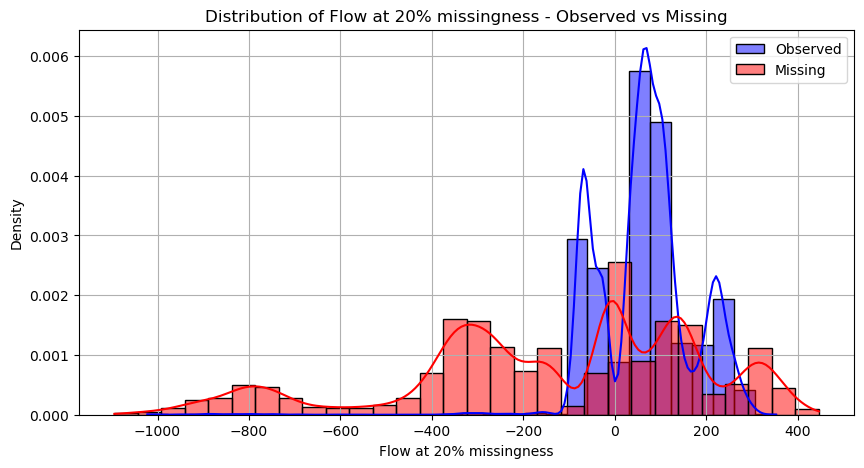

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_missing_vs_observed(data, mask, feature_name="flow"):
    """
    data: 1D array of original values
    mask: 1D boolean array, True if missing
    feature_name: for labeling
    """
    data_missing = data[mask]
    data_observed = data[~mask]

    plt.figure(figsize=(10, 5))
    sns.histplot(data_observed, color='blue', label='Observed', kde=True, stat="density", bins=30)
    sns.histplot(data_missing, color='red', label='Missing', kde=True, stat="density", bins=30)
    plt.title(f"Distribution of {feature_name} - Observed vs Missing")
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_missing_vs_observed(X_val_full_unscaled_seq_tensor[0].flatten(), val_masks_seq[0][99].flatten(), feature_name="Flow at 20% missingness")

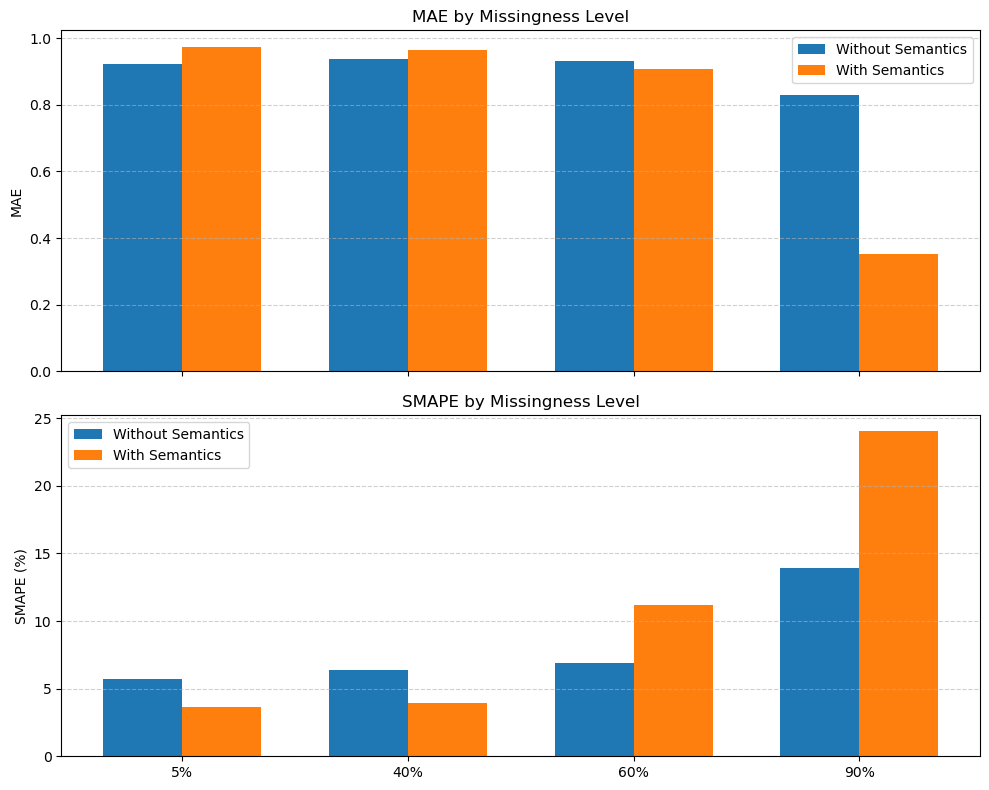

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Example error values (replace with your real variables)
missing_levels = ['5%', '40%', '60%', '90%']

# Bar chart setup
x = np.arange(len(missing_levels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- MAE plot ---
ax[0].bar(x - width/2, r2_all.values(), width, label='Without Semantics', color='tab:blue')
ax[0].bar(x + width/2, avg_r2_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[0].set_ylabel('MAE')
ax[0].set_title('MAE by Missingness Level')
ax[0].legend()
ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# --- SMAPE plot ---
ax[1].bar(x - width/2, smape_all.values(), width, label='Without Semantics', color='tab:blue')
ax[1].bar(x + width/2, avg_smape_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[1].set_ylabel('SMAPE (%)')
ax[1].set_title('SMAPE by Missingness Level')
ax[1].set_xticks(x)
ax[1].set_xticklabels(missing_levels)
ax[1].legend()
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()


With MNAR, mean imputation works much worse, around 40% SMAPE. On the other hand, BRITS with all features, and MNAR on 80% of values missingness on 30% of columns with values deviated from 70% of mean, performs 22% SMAPE.
When using only semantically relevant features with same percentage as above, SMAPE is 21% so almost no improvement. It seems that best improvements, in general, come when percentage of missing data is very big, which makes other features more important thus their relevance increases.

With 100% missingness of values above 0.5 treshold (so real 50% MNAR missingness in 30% of columns), SMAPE for average is  62%. 
For BRITS with all features, it is 26,62%.
For average imputation with semantically relevant features 51%, for BRITS with semantically relevant features, it is 11,21%. AMAZING IMPROVEMENT

## probar con otro modelo mas sencillo, mirar ultima celda distance